## Rover Project Perception Notebook
This notebook contains the functions from the lesson and provides the scaffolding you need to test out your mapping methods.  The steps you need to complete in this notebook for the project are the following:

* First just run each of the cells in the notebook, examine the code and the results of each.
* Run the simulator in "Training Mode" and record some data. Note: the simulator may crash if you try to record a large (longer than a few minutes) dataset, but you don't need a ton of data, just some example images to work with.   
* Change the data directory path (2 cells below) to be the directory where you saved data
* Test out the functions provided on your data
* Write new functions (or modify existing ones) to report and map out detections of obstacles and rock samples (yellow rocks)
* Populate the `process_image()` function with the appropriate steps/functions to go from a raw image to a worldmap.
* Run the cell that calls `process_image()` using `moviepy` functions to create video output
* Once you have mapping working, move on to modifying `perception.py` and `decision.py` to allow your rover to navigate and map in autonomous mode!

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

**Run the next cell to get code highlighting in the markdown cells.**

In [1]:
%%HTML
<style> code {background-color : orange !important;} </style>

In [2]:
%matplotlib inline
#%matplotlib qt # Choose %matplotlib qt to plot to an interactive window (note it may show up behind your browser)
# Make some of the relevant imports
import cv2 # OpenCV for perspective transform
import numpy as np
import matplotlib.image as mpimg
import pandas as pd
import matplotlib.pyplot as plt
import scipy.misc # For saving images as needed
import glob  # For reading in a list of images from a folder
import imageio
imageio.plugins.ffmpeg.download()

## Perspective Transform And Ray Based Represetation

### Implemented in Files:

1. perspective.py: calibrated perspective transform algorithm

2. ray_detect.py: construct geometric ray representation from particle representation generated by perspective transform

2. object_detect.py: image segmentation algorithm (by color thresholding) and detection

refer to ```writeup file``` and ```source code``` for more information about the technical details, here I describe the usage of these techniques.


In [3]:
from perspective import to_world_coords
from object_detect import segment_rock_sample
from rover_state import RoverState
from visualization import show_image

In [4]:
# load test dataset
df = pd.read_csv('../test_dataset/robot_log.csv', delimiter=';', decimal='.')
csv_img_list = df["Path"].tolist() # Create list of image pathnames
ground_truth = mpimg.imread('../calibration_images/map_bw.png')
ground_truth_3d = np.dstack((ground_truth*0, ground_truth*255, ground_truth*0)).astype(np.float)
def next_state(idx=None):
    if idx is None:
        idx = np.random.randint(0, len(df['Path']))
        print('current idx', idx)
    ret = RoverState()
    ret.img = plt.imread(df['Path'][idx])
    ret.pos = (df["X_Position"][idx], df["Y_Position"][idx])
    ret.yaw = df['Yaw'][idx]
    ret.roll = df['Roll'][idx]
    ret.pitch = df['Pitch'][idx]
    return ret

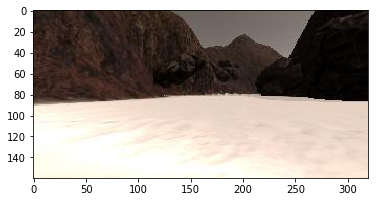

roll=2.093137e-07, pitch=0.0002364085, yaw=56.82555


In [5]:
### Original Frame, and RPY
state = next_state(idx=0)
show_image(state.img)
print('roll=%s, pitch=%s, yaw=%s' % (state.roll, state.pitch, state.yaw))

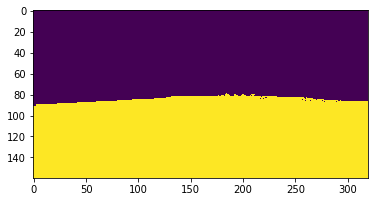

In [6]:
from object_detect import segment_navigable
## Segmentation of Terrain
navigable = segment_navigable(state.img)
show_image(navigable)

In [7]:
## create a perspective transformer, the associated parameters are included in rover_param.py
from perspective import CalibratedPerception
transformer = CalibratedPerception()

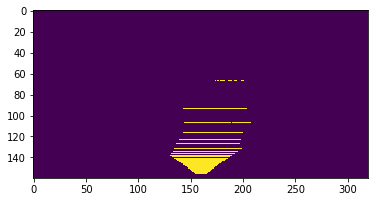

In [8]:
from visualization import render_particles
from visualization import show_image
from visualization import render_directions

# the transform takes roll pitch into account, hence it needs rover state to perform inference
# we can see the particles are sparsely distributed near sight singularity
navi = transformer.evaluate(state=state, image=navigable)
navi_render = render_particles(navi)
show_image(navi_render)

In [ ]:
from geometry import to_polar_coords
from ray_detect import particle_to_rays
from visualization import render_rays

# convert particle based representation to ray based representation for better geometric reasoning

# to polar coordinate
r, theta = to_polar_coords(navi[0], navi[1])

# mesh cluster particles to rays, keep only the particles of r in [0.5, 9.8], theta in [-60, 60] degree
rays = particle_to_rays(r, theta, max_angle=np.pi / 3, min_dist=0.5, max_dist=9.8)

# render the rays for visualization
rays_render = render_rays(rays)
show_image(rays_render)

# as we can see, the ray representation reflects the underlying geometric structure better than particles

## Direction Detection, Rock Sample Detection

### Source Files:

1. object_detect.py: image segmentation algorithm (by color thresholding) and detection
    
2. visualization.py: the visualization tools and functions


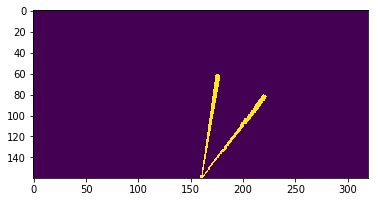

In [10]:
# detection directions from the ray representation
from object_detect import detect_directions

directions = detect_directions(rays)
direction_render = render_directions(directions)
show_image(direction_render)

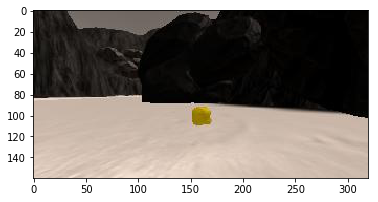

In [11]:
# segment rock samples
from object_detect import segment_rock_sample
image = plt.imread('../calibration_images/example_rock1.jpg')
show_image(image)

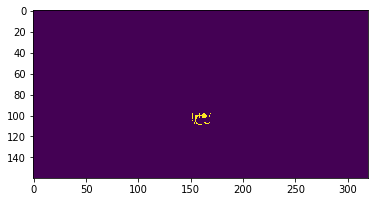

In [12]:
sample_segment = segment_rock_sample(image)
show_image(sample_segment)

## Video Demo

### Source Files:

1. process_image() function takes a rover state, modify current navi map and current rock sample map

2. make_video_clip() function takes a dataframe of the training record, and create a video and visualization of the perception stage.

In [58]:
# this function takes a state, returns a map update, front view perspective, detected directions
from visualization import rays_to_particles

def process_image(rover, current_map, current_sample):
    
    vision_img = np.zeros_like(rover.img, dtype=np.int8) + 128

    navi_segment = segment_navigable(rover.img)
    b_navi = transformer.evaluate(navi_segment, rover)
    r, theta = to_polar_coords(b_navi[0], b_navi[1])
    rays = particle_to_rays(
        r, theta, np.pi / 3, min_dist=0.5, max_dist=9.8)
    b_particles = rays_to_particles(rays, 0.1)
    navi_render = render_particles(b_particles)
    
    if b_particles.size != 0:
        w_navi = to_world_coords(b_particles, rover)
        current_map[w_navi[1], w_navi[0], 0] = 64
    
    sample_segment = segment_rock_sample(rover.img)
    
    b_samples = transformer.evaluate(sample_segment, rover)
    w_samples = to_world_coords(b_samples, rover)
    current_sample[w_samples[1], w_samples[0], :] = 0
    
    directions = detect_directions(rays)
    direction_render = render_directions(directions)
    vision_img[:, :, 0] = direction_render 

    return navi_render, direction_render

In [59]:
def make_backgroud_map(level, bg_color=(255, 255, 255)):
    # a white background
    bg = np.zeros_like(ground_truth_3d, dtype='uint8') + bg_color
    bg = bg.astype('uint8')
    coords = ground_truth.nonzero()
    bg[coords[0], coords[1], 0:2] = level
    return bg

def make_dataset_iterator(dataset):
    for idx in range(len(dataset['Path'])):
        ret = RoverState()
        ret.img = plt.imread(dataset['Path'][idx])
        ret.pos = (dataset["X_Position"][idx], dataset["Y_Position"][idx])
        ret.yaw = dataset['Yaw'][idx]
        ret.roll = dataset['Roll'][idx]
        ret.pitch = dataset['Pitch'][idx]
        yield ret

In [62]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from moviepy.editor import ImageSequenceClip


def gray_scale_to_rgb(img, channel, base=None):
    if base is None:
        ret = np.zeros(img.shape + (3,), dtype='uint8') + 255
    else:
        ret = base
    coords = img.nonzero()
    for i in range(3):
        if i != channel:
            ret[coords[0], coords[1], i] = 0
        else:
            ret[:, :, i] = img
    return ret


def pad_map_image(map_img):
    map_img = cv2.resize(map_img, (160, 160))
    blank = np.zeros((160, 80, 3), dtype='uint8') + 255
    ret = np.concatenate((blank, map_img, blank), axis=1)
    return ret


def horiz_cat_map(left, right):
    left = cv2.resize(left, (160, 160))
    right = cv2.resize(right, (160, 160))
    ret = np.concatenate((left, right), axis=1)
    return ret


def put_text(img, text):
    img = cv2.putText(img, text, (20, 20), 
                cv2.FONT_HERSHEY_COMPLEX, 0.4, (0, 0, 0), 1)
    return img

def make_clip(visions):
    clips = []
    for i in range(len(visions)):
        perspect = gray_scale_to_rgb(visions[i][1], channel=2)
        direction = gray_scale_to_rgb(visions[i][2], channel=0)
        perspect = put_text(perspect, 'Front Perspective View')
        direction = put_text(direction, 'Direction Detection')
        map_img = horiz_cat_map(visions[i][3], visions[i][4])
        ret_0 =  np.concatenate((visions[i][0], perspect), axis=0)
        ret_1 = np.concatenate((direction, map_img), axis=0)
        ret = np.concatenate((ret_0, ret_1), axis=1)
        clips.append(ret)
    return ImageSequenceClip(clips, fps=25)


def make_video_clip(dataset):
    iterator = make_dataset_iterator(dataset)
    cur_map = make_backgroud_map(200, bg_color=(255, 255, 255))
    cur_map = put_text(cur_map,"Navigation Map")
    
    cur_sample = make_backgroud_map(200, bg_color=(200, 255, 255))
    cur_sample = put_text(cur_sample,"Sample Map")
    
    visions = []
    for i, state in enumerate(iterator):
        if i % 100 == 0:
            print('processed %d frames' % i)
        cur_map = np.copy(cur_map)
        cur_sample = np.copy(cur_sample)
        navi, direction = process_image(state, cur_map, cur_sample)
        visions.append((state.img, navi, direction, cur_map, cur_sample))  
    clip = make_clip(visions)
    return clip

### Make a Video of The Provided Test Dataset

In [63]:
clips = make_video_clip(df)

processed 0 frames
processed 100 frames
processed 200 frames


In [49]:
output = '../output/test_mapping.mp4'
%time clips.write_videofile(output,audio=False)

[MoviePy] >>>> Building video ../output/test_mapping.mp4
[MoviePy] Writing video ../output/test_mapping.mp4


100%|██████████| 283/283 [00:00<00:00, 459.13it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ../output/test_mapping.mp4 

CPU times: user 92 ms, sys: 68 ms, total: 160 ms
Wall time: 788 ms


In [50]:
from IPython.display import HTML
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output))

### Make a Video of My Own Recorded Dataset

In [64]:
new_dataset = pd.read_csv('../new_dataset/robot_log.csv', delimiter=';', decimal='.')
new_clip = make_video_clip(new_dataset)

processed 0 frames
processed 100 frames
processed 200 frames
processed 300 frames
processed 400 frames
processed 500 frames
processed 600 frames
processed 700 frames
processed 800 frames
processed 900 frames
processed 1000 frames
processed 1100 frames
processed 1200 frames
processed 1300 frames
processed 1400 frames
processed 1500 frames
processed 1600 frames
processed 1700 frames
processed 1800 frames
processed 1900 frames
processed 2000 frames
processed 2100 frames
processed 2200 frames
processed 2300 frames
processed 2400 frames
processed 2500 frames
processed 2600 frames
processed 2700 frames
processed 2800 frames
processed 2900 frames
processed 3000 frames
processed 3100 frames
processed 3200 frames
processed 3300 frames
processed 3400 frames
processed 3500 frames
processed 3600 frames
processed 3700 frames
processed 3800 frames
processed 3900 frames
processed 4000 frames
processed 4100 frames
processed 4200 frames
processed 4300 frames
processed 4400 frames
processed 4500 frames


In [65]:
output = '../output/new_mapping.mp4'
%time new_clip.write_videofile(output,audio=False)

[MoviePy] >>>> Building video ../output/new_mapping.mp4
[MoviePy] Writing video ../output/new_mapping.mp4


100%|██████████| 5466/5466 [00:14<00:00, 388.77it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ../output/new_mapping.mp4 

CPU times: user 8.7 s, sys: 1.12 s, total: 9.83 s
Wall time: 14.3 s


In [66]:
from IPython.display import HTML
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output))